In [45]:
import numpy as np
import pandas as pd 

import sys
import os
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

In [121]:
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 1.Load Data

In [25]:
DATASETS_HOUSE = Path('../datasets/housing/housing.csv')
TMP_DIR = Path('../datasets/tmp/')

In [19]:
df_house = pd.read_csv(DATASETS_HOUSE)

In [21]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [31]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_house, test_size=0.2, random_state=2)

In [35]:
train_set.to_excel(os.path.join(TMP_DIR,'house_train.xlsx'))

In [41]:
train_set.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2072,-119.84,36.77,6.0,1853.0,473.0,1397.0,417.0,1.4817,72000.0,INLAND
10600,-117.80,33.68,8.0,2032.0,349.0,862.0,340.0,6.9133,274100.0,<1H OCEAN
2494,-120.19,36.60,25.0,875.0,214.0,931.0,214.0,1.5536,58300.0,INLAND


# 2.EDA

## 2.1.查看目标变量

 - <font color='red'>训练记录</font>操作：删除房价500001的记录

In [44]:
train_set['median_house_value'].describe()

count     16512.000000
mean     206509.251453
std      115225.957661
min       14999.000000
25%      119400.000000
50%      179300.000000
75%      264500.000000
max      500001.000000
Name: median_house_value, dtype: float64

Skewness: 0.977421
Kurtosis: 0.328713
Drop Upperlimit Skewness: 0.807335
Drop Upperlimit Kurtosis: 0.148738


<Figure size 900x800 with 0 Axes>

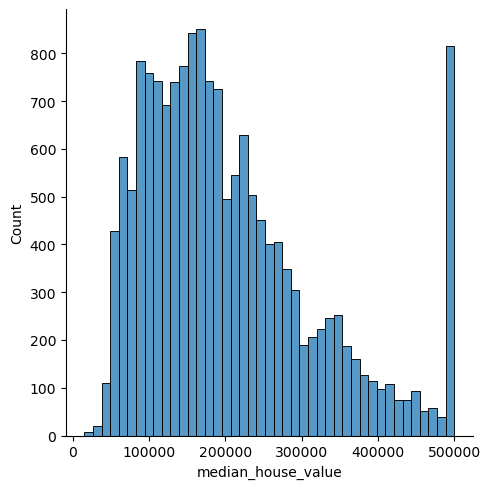

In [114]:
train_set['y_upperlimit'] = (train_set['median_house_value']==500001) * 1

print('Skewness: %f' % train_set['median_house_value'].skew())
print('Kurtosis: %f' % train_set['median_house_value'].kurt())

print('Drop Upperlimit Skewness: %f' % train_set.loc[train_set['y_upperlimit'] != 1, 'median_house_value'].skew())
print('Drop Upperlimit Kurtosis: %f' % train_set.loc[train_set['y_upperlimit'] != 1, 'median_house_value'].kurt())

plt.figure(figsize=(9,8))
sns.displot(train_set['median_house_value'])
plt.show()

## 2.2.数值特征分布

### 2.2.1.单变量特征

In [85]:
list(set(train_set.dtypes.to_list()))

[dtype('int32'), dtype('float64'), dtype('O')]

In [86]:
train_num = train_set.select_dtypes(include = ['float64', 'int64'])
train_num.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
2072,-119.84,36.77,6.0,1853.0,473.0,1397.0,417.0,1.4817,72000.0
10600,-117.80,33.68,8.0,2032.0,349.0,862.0,340.0,6.9133,274100.0
2494,-120.19,36.60,25.0,875.0,214.0,931.0,214.0,1.5536,58300.0


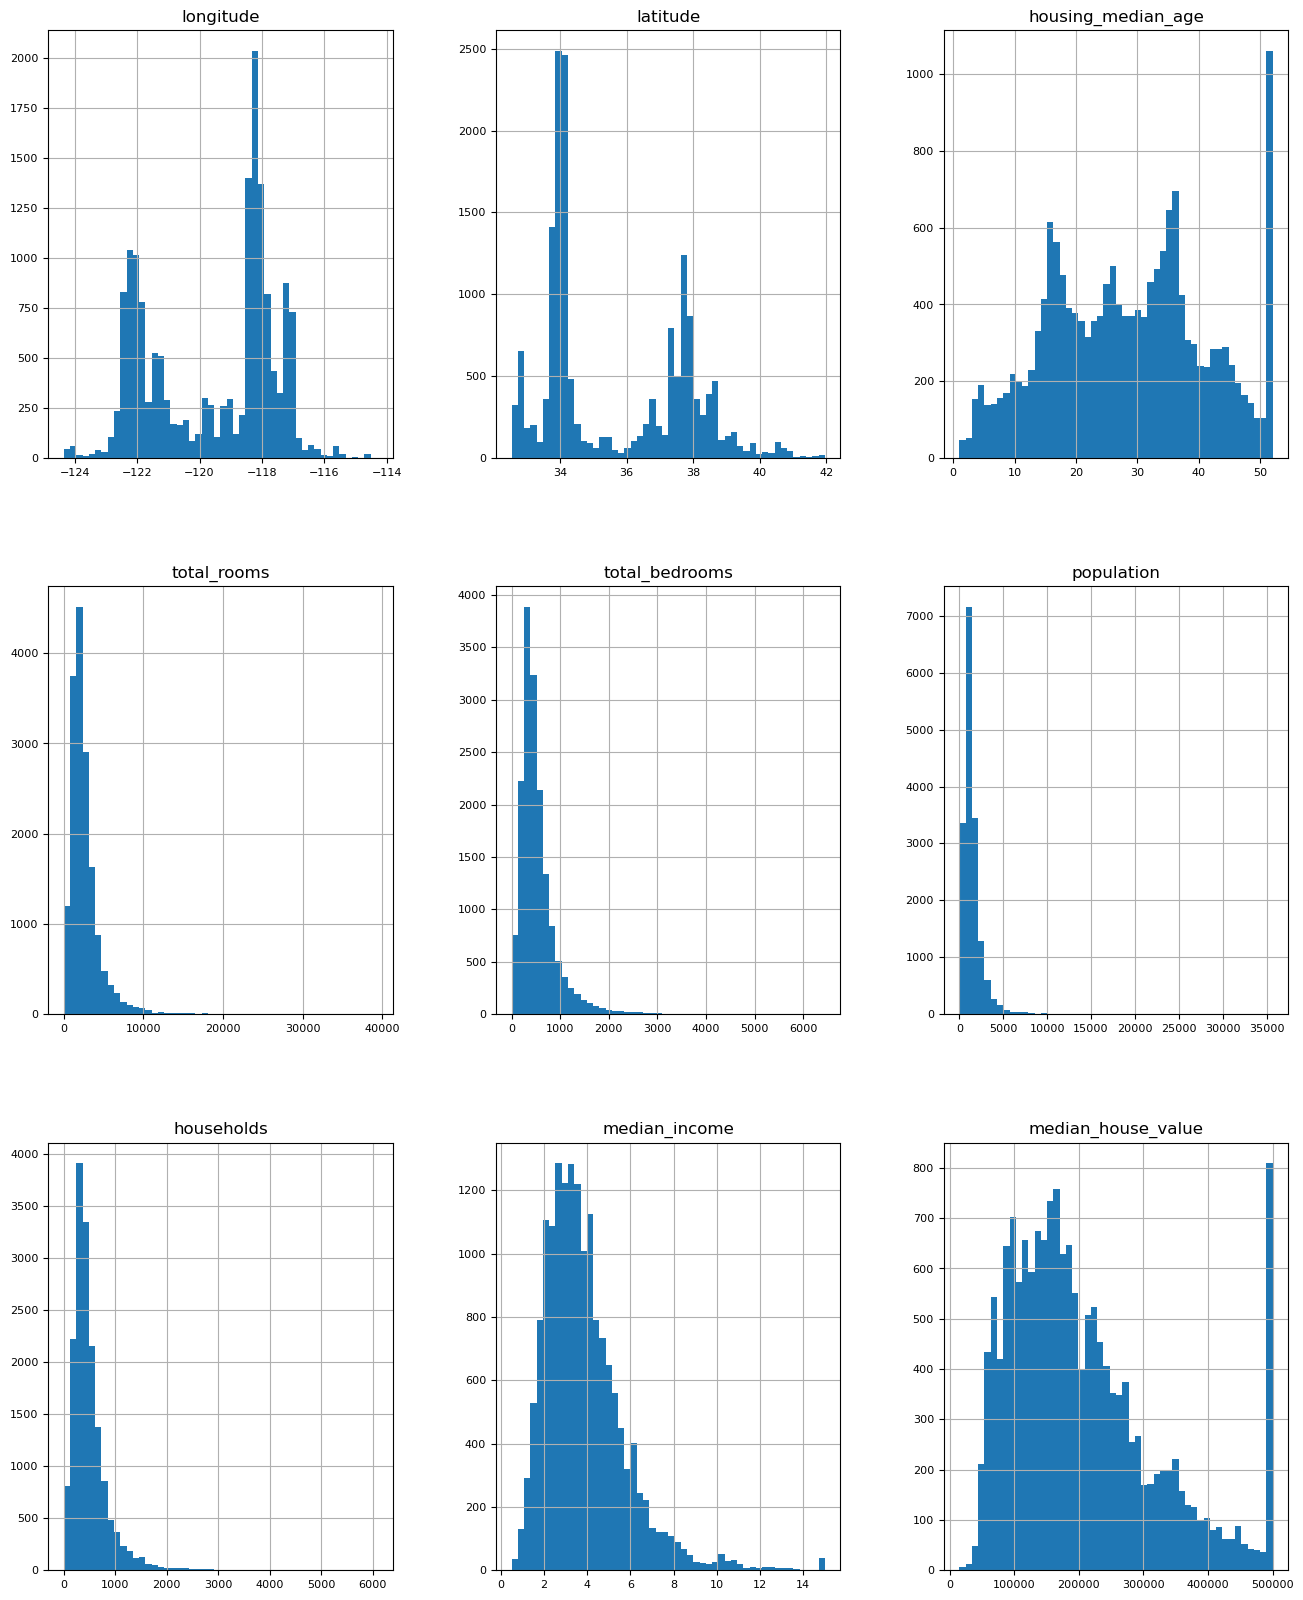

In [87]:
train_num.hist(figsize=(16,20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

### 2.2.2.相关特征

In [116]:
corr_matrix = train_num.corr()

In [118]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.689659
total_rooms           0.133218
housing_median_age    0.108626
households            0.063245
total_bedrooms        0.047478
population           -0.027441
longitude            -0.046754
latitude             -0.143970
Name: median_house_value, dtype: float64

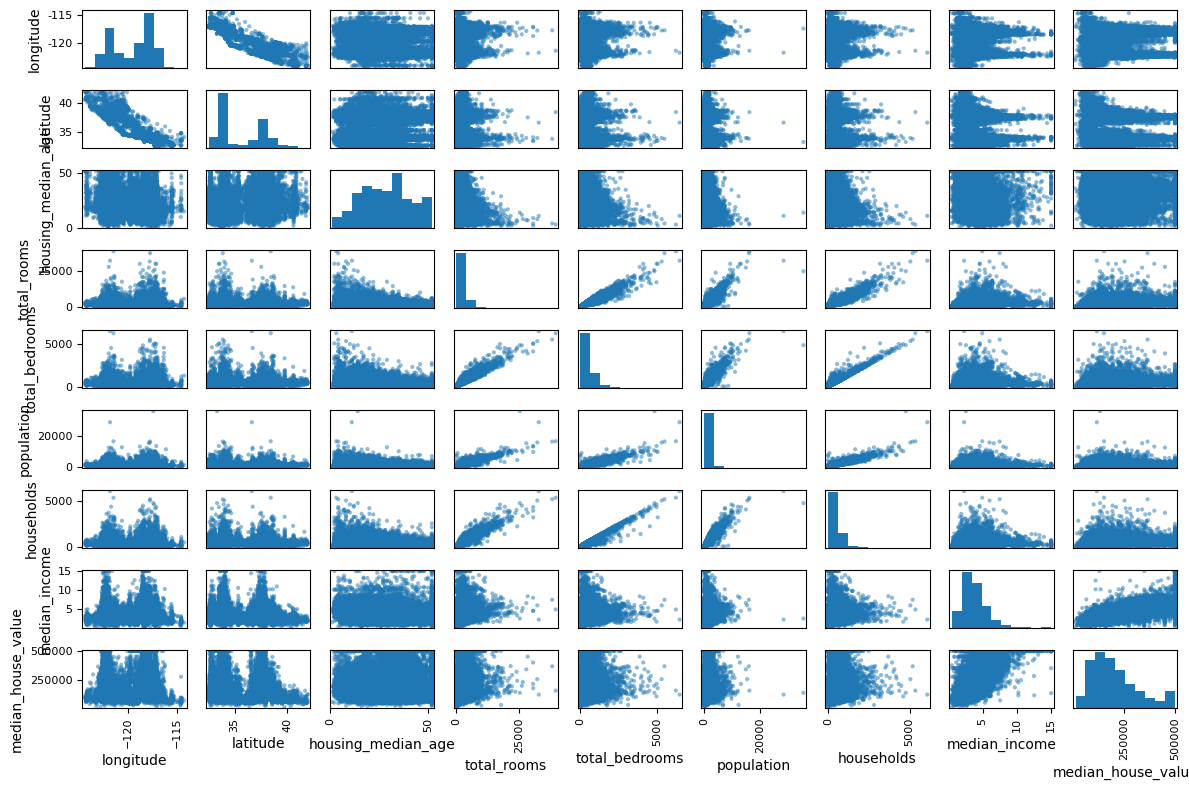

In [122]:
from pandas.plotting import scatter_matrix

scatter_matrix(train_num, figsize=(12, 8))
save_fig("scatter_matrix_plot")  # extra code
plt.show()

### 2.3.分类特征

In [125]:
train_cat = train_set.select_dtypes(include = ['object'])

In [138]:
ocean_cnt = train_cat['ocean_proximity'].value_counts()
ocean_freq = train_cat['ocean_proximity'].value_counts() / train_cat.shape[0]
ocean_freq.name = 'freq'

pd.concat([ocean_cnt,ocean_freq],axis = 1)

,count,freq
ocean_proximity,,
<1H OCEAN,7312,0.442829
INLAND,5235,0.317042
NEAR OCEAN,2140,0.129603
NEAR BAY,1821,0.110283
ISLAND,4,0.000242


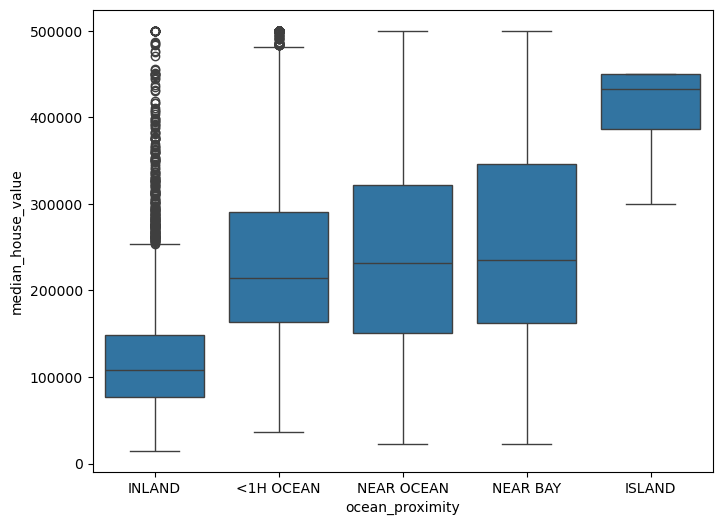

In [140]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='ocean_proximity', y="median_house_value", data=train_set)
plt.show()

# 3.特征预处理 

## 3.1.缺失值处理

 - 处理方式一：用households的去填补
 - 处理方式二：直接删去这个字段，因为household共线性比较强

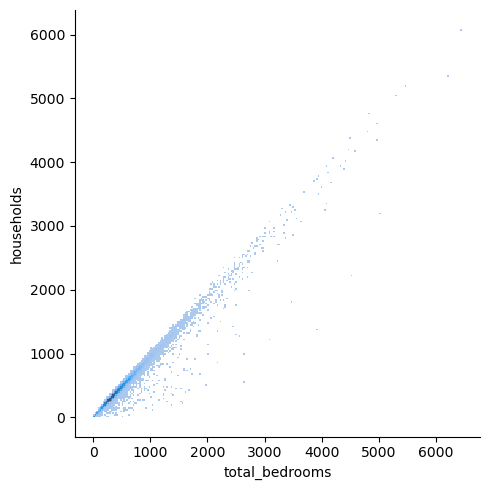

In [149]:
sns.displot(train_set,x='total_bedrooms', y='households')

In [151]:
def feature_drop_na(df):
    df = train_set.drop(columns='total_bedrooms')
    return df

## 3.2 文本变量处理

In [166]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(handle_unknown='ignore')
ocean_1hot = cat_encoder.fit_transform(train_set[['ocean_proximity']])

In [172]:
# 由于ISLAND记录太少，暂时不将其作为特征
ocean_1hot.

array([7.312e+03, 5.235e+03, 4.000e+00, 1.821e+03, 2.140e+03])